In [1]:
import matplotlib
rc_fonts = {
    "font.size": 14,
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3dexp.db

from utils import get_by_expnames, get_by_ext, pretty

In [2]:
# when disk is saturated: 
# how many cores: avg_cpu_ms / avg_wall_ms

data = [
    # baseline (not sort): take 16 threads
    ('redness', 'baseline', 2.93, 10.75, 25.7),
    ('hash', 'baseline', 2.9, 10.35, 25.79),
    ('resnet10', 'baseline', 3.63, 10.34, 20.74),
    # smart sorted: take 8 threads
    ('redness', 'smart', .78, 4.54, 1328.4),
    ('hash', 'smart', .74, 4.03, 1408.6),
    ('resnet10', 'smart', .73, 3.99, 1422.12)
]

df = pd.DataFrame(data, columns=['workload', 'disk', 'avg_wall_ms', 'avg_cpu_ms', 'bandwidth'])
df['throughput'] = 1000. / df['avg_wall_ms']
df

,workload,disk,avg_wall_ms,avg_cpu_ms,bandwidth,throughput
0,redness,baseline,2.93,10.75,25.70,341.296928
1,hash,baseline,2.90,10.35,25.79,344.827586
2,resnet10,baseline,3.63,10.34,20.74,275.482094
3,redness,smart,0.78,4.54,1328.40,1282.051282
4,hash,smart,0.74,4.03,1408.60,1351.351351
5,resnet10,smart,0.73,3.99,1422.12,1369.863014


41666.6666667
  workload      disk  avg_wall_ms  avg_cpu_ms  bandwidth   throughput
0  redness  baseline         2.93       10.75       25.7   341.296928
3  redness     smart         0.78        4.54     1328.4  1282.051282


<IPython.core.display.Javascript object>


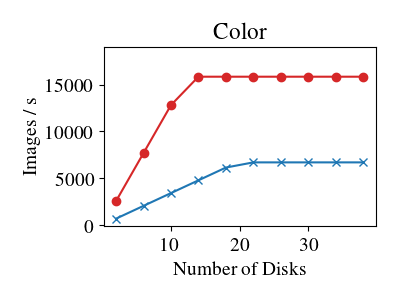

10.75 341.296928328
4.54 1282.05128205
  workload      disk  avg_wall_ms  avg_cpu_ms  bandwidth   throughput
1     hash  baseline         2.90       10.35      25.79   344.827586
4     hash     smart         0.74        4.03    1408.60  1351.351351


<IPython.core.display.Javascript object>


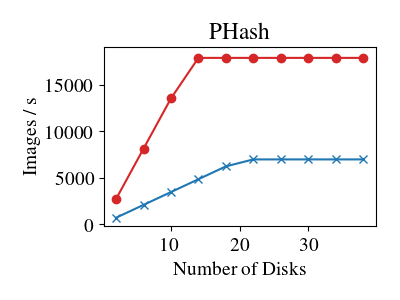

10.35 344.827586207
4.03 1351.35135135
   workload      disk  avg_wall_ms  avg_cpu_ms  bandwidth   throughput
2  resnet10  baseline         3.63       10.34      20.74   275.482094
5  resnet10     smart         0.73        3.99    1422.12  1369.863014


<IPython.core.display.Javascript object>


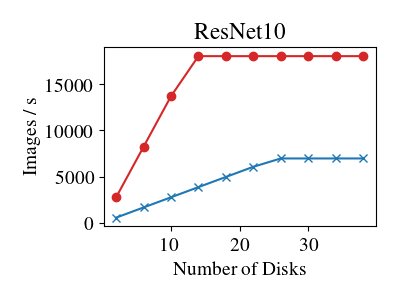

10.34 275.482093664
3.99 1369.8630137


In [44]:
%matplotlib notebook

N_CPU = 72

MAX_DISK = 40
STEP = 4

# by GPU
RESNET10_MAX_TPUT = 1. / .000024
print RESNET10_MAX_TPUT

for workload in ['redness', 'hash', 'resnet10']:
    df1 = df[df['workload'] == workload]
    print df1
    
    plt.figure(figsize=(4,3))

    x = np.arange(2, MAX_DISK, STEP, dtype=np.int)
    
    for dev, dev_name, mk, c in [('baseline', 'Standard Disk', 'x', 'tab:blue'), ('smart', 'Decode-Enabled Storage', 'o', 'tab:red')]:
        avg_cpu_ms, tput_per_disk = df1[df1['disk']==dev][['avg_cpu_ms', 'throughput']].iloc[0]
        
        print avg_cpu_ms, tput_per_disk
        
        total_tput = np.minimum(x * tput_per_disk, N_CPU * 1e3 / avg_cpu_ms)
        
        plt.plot(x, total_tput, '-'+mk, label=dev_name, color=c)
        
    plt.title(pretty(workload))
    plt.xlabel("Number of Disks")
    plt.ylabel("Images / s")
    plt.ylim(None, 19000)
    

#     if workload == 'resnet10': # hack
#         plt.legend(loc='center right', bbox_to_anchor=(1., .7))
#     else:
#         plt.legend(loc='best', fontsize=13)

#     plt.legend(loc='center right', bbox_to_anchor=(1, 0.6), fontsize=10, labelspacing=0.1)
#     plt.legend(loc='best', fontsize=13)
        
    plt.tight_layout()
    plt.show()

    plt.savefig("scaling-{}.pdf".format(workload), bbox_inches='tight')

In [ ]:
N_CPU = 16
SATA = 500
NVME2000 = 2000
NVME6000 = 6000

In [ ]:
for disk, bus in zip(['baseline', 'smart', 'smart'], [SATA, NVME2000, NVME6000]):
    df1 = df[df['disk']==disk].copy()
    df1['n_disk_by_cpu'] = N_CPU*1e3 / (df1['avg_cpu_ms'] * df1['throughput'])
    df1['n_disk_by_bus'] = bus / df1['bandwidth']
    df1['n_disk'] = df1[['n_disk_by_cpu', 'n_disk_by_bus']].min(axis=1)
    df1['achievable_tput'] = df1['throughput'] * df1['n_disk']
    print df1[['workload', 'disk', 'n_disk_by_cpu', 'n_disk_by_bus', 'n_disk', 'achievable_tput']]

<IPython.core.display.Javascript object>


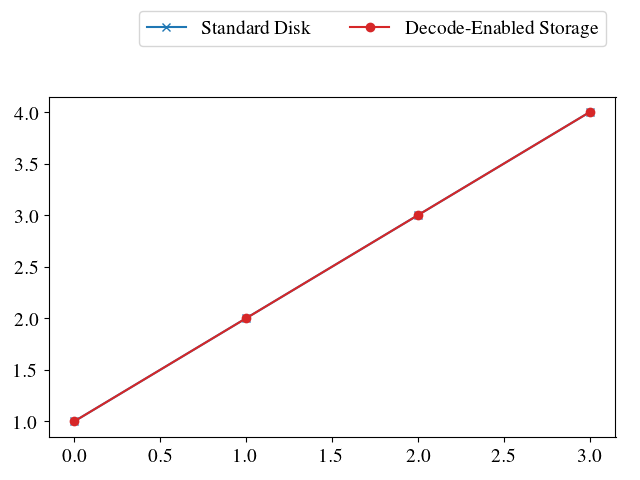

In [41]:
%matplotlib notebook
# plot a legend separately
# plt.figure(figsize=(4,3))
for dev, dev_name, mk, c in [('baseline', 'Standard Disk', 'x', 'tab:blue'), ('smart', 'Decode-Enabled Storage', 'o', 'tab:red')]:
    plt.plot([1,2,3,4], '-'+mk, label=dev_name, color=c)
    plt.legend(loc='center right', bbox_to_anchor=(1, 1.2), ncol=2)
        
    plt.tight_layout()
    plt.show()
    plt.savefig("scaling-legend.pdf", bbox_inches='tight')